In [2]:
import pickle
import pandas as pd
from connections import AWS
from sklearn.metrics import root_mean_squared_error, r2_score

$\textbf{EVT Model Performance Summary}$

- Model error report
- Post-hoc analysis plots (error distributions, bland altmann plots)

In [3]:
""" INITIALIZE AWS CONNECTION """
aws_connection = AWS()
aws_connection.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


In [46]:
# load model preds
model_preds = aws_connection.load_s3_object('biomechanics/ml/modeling_summary/model_preds.csv')
model_preds = model_preds[model_preds['peak_value'] > 45]

# compute rmse by model
rmse_rf = root_mean_squared_error(model_preds['peak_pred_rf'], model_preds['peak_value'])   # 4.61 Nm
rmse_lr = root_mean_squared_error(model_preds['peak_pred_lr'], model_preds['peak_value'])   # 21.41 Nm
r2_rf = r2_score(model_preds['peak_pred_rf'], model_preds['peak_value'])   # 0.95

# add errors to model_predsframe
model_preds['rf_error'] = model_preds['peak_pred_rf'] - model_preds['peak_value']
model_preds['lr_error'] = model_preds['peak_pred_lr'] - model_preds['peak_value']

$\textit{Plots}$

Both of the following for random forest errors:
- Residual distribution relative to standard normal
- Bland Altmann

$\textbf{Sandbox: Data Summary}$

Averages are reported in publications as follows: 
- LHP mirrored to match RHP
- Ball tracking converted to metric system

In [37]:
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

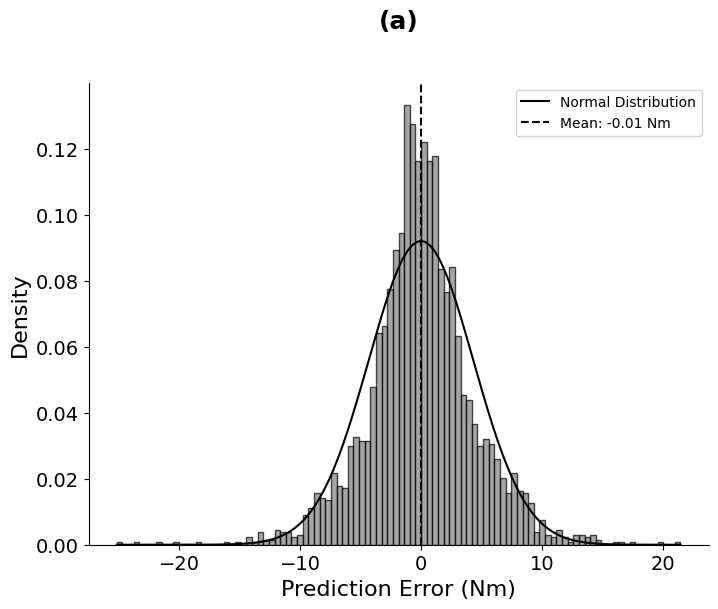

In [38]:
# calculate the mean and standard deviation of 'rf_error'
mean_error = model_preds['rf_error'].mean()
std_error = model_preds['rf_error'].std()

# create the histogram
plt.hist(model_preds['rf_error'], bins=100, color='gray', alpha=0.7, density=True, edgecolor='black')

# overlay the normal distribution
x = np.linspace(model_preds['rf_error'].min(), model_preds['rf_error'].max(), 1000)

# overlay the normal distribution
hist_values, bin_edges = np.histogram(model_preds['rf_error'], bins=100, density=True)
pdf = norm.pdf(x, mean_error, std_error)
plt.plot(x, pdf, color='black', label='Normal Distribution')

# make the plot taller
plt.gcf().set_size_inches(8, 6)

# add a vertical line for the mean
plt.axvline(mean_error, color='black', linestyle='--', label=f'Mean: {mean_error:.2f} Nm')

# add labels and legend
plt.title('(a)', fontsize=18, fontweight='bold', y=1.10)
plt.xlabel('Prediction Error (Nm)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend()

# remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# make tick marks larger
plt.tick_params(axis='both', which='major', labelsize=14)

# show the plot
plt.show()

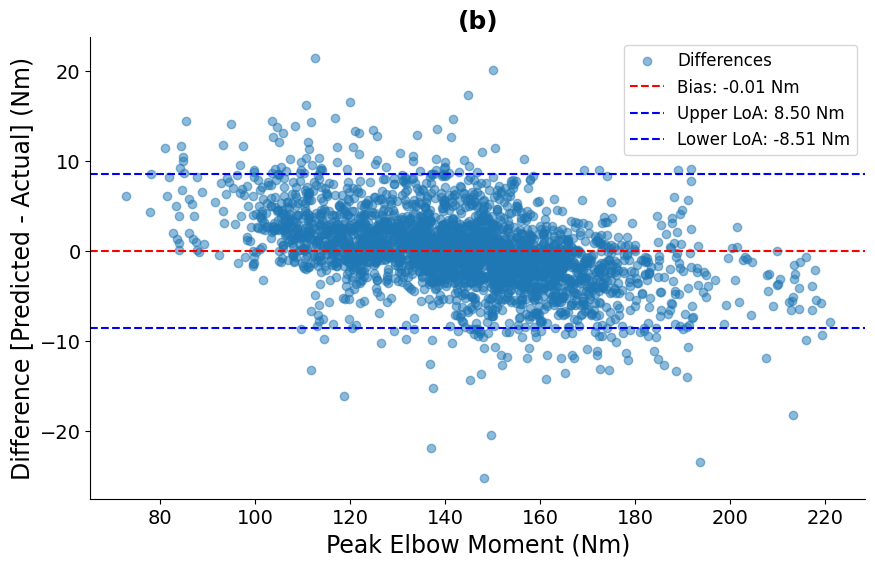

In [39]:
""" Bland-Altman Plot """
# calculate the mean difference (bias) and the 95% limits of agreement
mean_diff = model_preds['peak_pred_rf'] - model_preds['peak_value']
bias = mean_diff.mean()
loa_upper = bias + 1.96 * mean_diff.std()
loa_lower = bias - 1.96 * mean_diff.std()

# create the Bland-Altman plot
plt.figure(figsize=(10, 6))
plt.scatter(model_preds['peak_value'], mean_diff, alpha=0.5, label='Differences')
plt.axhline(bias, color='red', linestyle='--', label=f'Bias: {bias:.2f} Nm')
plt.axhline(loa_upper, color='blue', linestyle='--', label=f'Upper LoA: {loa_upper:.2f} Nm')
plt.axhline(loa_lower, color='blue', linestyle='--', label=f'Lower LoA: {loa_lower:.2f} Nm')

# add labels and legend
plt.title('(b)', fontsize=18, fontweight='bold')
plt.xlabel('Peak Elbow Moment (Nm)', fontsize=17)
plt.ylabel('Difference [Predicted - Actual] (Nm)', fontsize=17)
plt.legend(fontsize=12)

# remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# make tick marks larger
plt.tick_params(axis='both', which='major', labelsize=14)

# show the plot
plt.show()

In [44]:
np.corrcoef(model_preds['peak_pred_rf'], model_preds['peak_value'])

array([[1.        , 0.98344118],
       [0.98344118, 1.        ]])

$\textbf{Close AWS Connection}$

In [4]:
aws_connection.close()

[AWS]: Database connection closed.
[AWS]: SSH tunnel stopped.
